In [93]:
#Import statements
from scipy.io import loadmat
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from copy import deepcopy
import math
from matplotlib import gridspec
from PIL import Image
import pandas as pd
import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [94]:
'''Adapted from stack overflow response from Jeru Luke, 
https://stackoverflow.com/questions/51285593/converting-an-image-to-grayscale-using-numpy

Takes in color image and converts to gray scale'''
def grayConversion(image):
    grayValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
    gray_img = grayValue.astype(np.uint8)
    return gray_img

def spectroPlot(Sgt_spec, tslide, ks, xlim, ylim, title):
    '''spectroPlot generates a spectrogram plot of Gabor filtered two dimensional signal data
    
    INPUT:
    Sgt_spec: Sgt_spec: numpy.ndarray of fourier transformed and shifted data in each time bin
    tslide: numpy.ndarray of the time bins used in analysis
    ks: numpy.ndarray of shifted wave numbers
    xlim: tuple indicating x axis minimum and maximum (min, max)
    ylim: tuple indicating y axis minimum and maximum (min, max)'''
    
    f, ax = plt.subplots()
    ax.pcolormesh(tslide, ks, np.transpose(Sgt_spec), cmap = 'hot')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(title)
    ax.set(xlim = xlim, ylim = ylim)
'''Function that plots an ROC curve per class of a multiclass classifier case
by using the One Vs Rest technique.  This function was adapted from code
at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
demonstrating the multiclass implementation of ROC curves for classifier
evaluation.

Inputs:
    X_train: dataframe object containing the data to train on.
    y_train: dataframe object containing the label binarized class outputs of 
            the training set.
    X_test: dataframe object containing the data for testing the model
    y_test: dataframe object containing the label binarized class outputs of
            the test set.
    model: classifier object delineating the model to fit
    classes: list containing the classes of the data to be used in plotting

Outputs:
    ROC curve plot containing curves for each class, as well as the micro and
    macro average ROC curves.
'''
def multiclassROC(X_train, y_train, X_test, y_test, model, classes):
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_train = label_binarize(y_train, classes=np.unique(y_train))
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_train.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    lw=2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    start = 0.0
    stop = 1.0
    number_of_lines= n_classes
    cm_subsection = np.linspace(start, stop, number_of_lines) 
    colors = [ cm.jet(x) for x in cm_subsection ]
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Multiclass')
    plt.legend(bbox_to_anchor=(1.00, 1.00))
    plt.show()
    
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Adapted from code at: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    bottom, top = plt.ylim() 
    plt.ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
#cropped image flattening and data matrix concatenation
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/CroppedYale/"
cropped_faces = []
for subdir, dirs, files in os.walk(parent_dir):
    for d in dirs:
        abs_path = os.path.join(parent_dir, d)
        for subdir, dirs, files in os.walk(parent_dir + d + "/"):
            for file in files:
                im_path = os.path.join(abs_path, file)
                face = cv2.imread(im_path, -1)
                cropped_faces.append(face)
flat_faces = []
for i in range(0, len(cropped_faces)):
    flat_face = cropped_faces[i].flatten()
    flat_faces.append(flat_face)
cropped_data = np.transpose(np.array(flat_faces))

Text(0.5, 0, 'Mode')

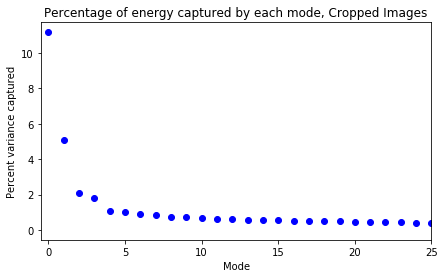

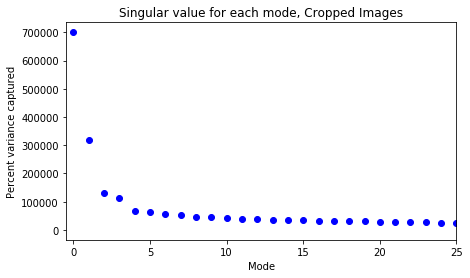

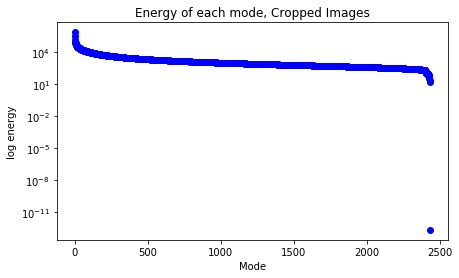

In [4]:
#Apply SVD to cropped faces data
pix, fac = cropped_data.shape#pix = pixels, fac = faces
#Subtract off the mean for each row of data
average_face = np.mean(cropped_data, axis=1)#compute average column of the cropped data matrix (i.e. the average face)
'''
X = np.empty((pix, fac))

for i in range(0, fac):
    col_av = np.average(cropped_data[:,i])
    col_centered = cropped_data[:,i] - col_av
    X[:,i] = col_centered

'''
X = cropped_data
#Compute SVD
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)


#Plot percentage of variance captured by differnt modes
#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot((Sigma / sum(Sigma)) * 100, 'bo')
ax1.set_title('Percentage of energy captured by each mode, Cropped Images')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -0.5, 25))

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(Sigma, 'bo')
ax1.set_title('Singular value for each mode, Cropped Images')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -0.5, 25))

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.semilogy(np.arange(1, fac + 1), Sigma, 'bo')
ax1.set_title('Energy of each mode, Cropped Images')
ax1.set_ylabel('log energy')
ax1.set_xlabel('Mode')
#ax1.set_xlim(( -0.5, 25))
#ax1.set_ylim((10**-3, 10**1))

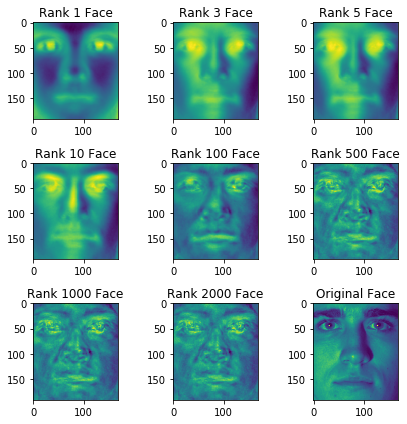

In [5]:
#Project onto the left singular vectors, compare reconstructed images to originals
Sigma_mat = np.diag(Sigma)
ranks = [1, 3, 5, 10, 100, 500, 1000, 2000]
image = 5

cols = 3
rows = int(math.ceil((len(ranks) + 1) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(2*rows, 2*cols))
for i in range(0, len(ranks) + 1):
    ax = fig.add_subplot(gs[i])
    #if loop has gone through all desired ranks, lastly plot the original image
    if i == len(ranks):
        X_r_reshape = X[:, image].reshape(cropped_faces[image].shape)#set the X_r_reshape to be original image for plotting
        ax.set_title('Original Face')
    else:
        rank_reducer = np.ones(fac)
        rank_reducer[ranks[i]:] = 0
        sm = np.dot(Sigma_mat, np.diag(rank_reducer))
        X_r = np.dot(U, np.dot(sm, np.transpose(VT)))
        X_r_reshape = (X_r[:, image]).reshape(cropped_faces[image].shape)
        ax.set_title('Rank ' + str(ranks[i]) + ' Face')
    
    ax.imshow(X_r_reshape)
fig.tight_layout()

In [15]:
#uncropped image flattening and data matrix concatenation
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/yalefaces_uncropped/"
uncropped_faces = []
for subdir, dirs, files in os.walk(parent_dir):
    for d in dirs:
        abs_path = os.path.join(parent_dir, d)
        for subdir, dirs, files in os.walk(parent_dir + d + "/"):
            for file in files:
                im_path = os.path.join(abs_path, file)
                gif = cv2.VideoCapture(im_path)
                ret,frame = gif.read() # ret=True if it finds a frame else False. Since your gif contains only one frame, the next read() will give you ret=False
                image = Image.fromarray(frame)
                face = grayConversion(np.array(image))
                uncropped_faces.append(face)
flat_faces = []
for i in range(0, len(uncropped_faces)):
    flat_face = uncropped_faces[i].flatten()
    flat_faces.append(flat_face)
uncropped_data = np.transpose(np.array(flat_faces))

Text(0.5, 0, 'Mode')

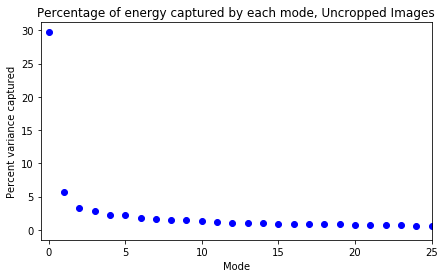

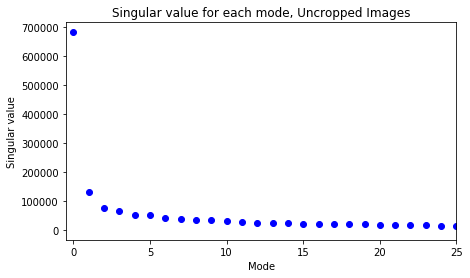

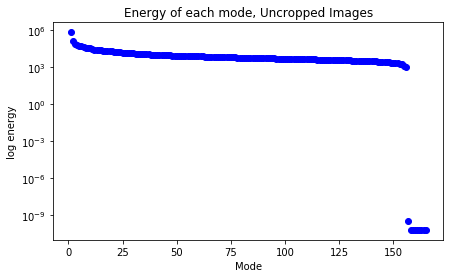

In [16]:
#Apply SVD to cropped faces data
pix, fac = uncropped_data.shape#pix = pixels, fac = faces
#Subtract off the mean for each row of data
average_face = np.mean(uncropped_data, axis=1)#compute average column of the cropped data matrix (i.e. the average face)

Xuc = uncropped_data


#Compute SVD
U, Sigma, VT = np.linalg.svd(Xuc, full_matrices=False)


#Plot percentage of variance captured by differnt modes
#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot((Sigma / sum(Sigma)) * 100, 'bo')
ax1.set_title('Percentage of energy captured by each mode, Uncropped Images')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -0.5, 25))

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(Sigma, 'bo')
ax1.set_title('Singular value for each mode, Uncropped Images')
ax1.set_ylabel('Singular value')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -0.5, 25))

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.semilogy(np.arange(1, fac + 1), Sigma, 'bo')
ax1.set_title('Energy of each mode, Uncropped Images')
ax1.set_ylabel('log energy')
ax1.set_xlabel('Mode')
#ax1.set_xlim(( -0.5, 25))
#ax1.set_ylim((10**-3, 10**1))

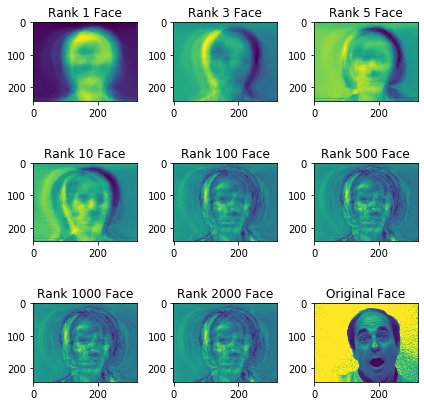

In [17]:
#Project onto the left singular vectors, compare reconstructed images to originals
Sigma_mat = np.diag(Sigma)
ranks = [1, 3, 5, 10, 100, 500, 1000, 2000]
image = 5

cols = 3
rows = int(math.ceil((len(ranks) + 1) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(2*rows, 2*cols))
for i in range(0, len(ranks) + 1):
    ax = fig.add_subplot(gs[i])
    #if loop has gone through all desired ranks, lastly plot the original image
    if i == len(ranks):
        X_r_reshape = (Xuc[:, image]/np.sqrt(fac - 1)).reshape(uncropped_faces[image].shape)#set the X_r_reshape to be original image for plotting
        ax.set_title('Original Face')
    else:
        rank_reducer = np.ones(fac)
        rank_reducer[ranks[i]:] = 0
        sm = np.dot(Sigma_mat, np.diag(rank_reducer))
        X_r = np.dot(U, np.dot(sm, np.transpose(VT)))
        X_r_reshape = (X_r[:, image]).reshape(uncropped_faces[image].shape)
        ax.set_title('Rank ' + str(ranks[i]) + ' Face')
    
    ax.imshow(X_r_reshape)
fig.tight_layout()

In [148]:
#PART II
from pydub import AudioSegment
'''
# convert mp3 files to wav files                                                         
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/Part1_songs/"
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".mp3"):
            song_path = os.path.join(parent_dir, file)#get os path of song
            sound = AudioSegment.from_mp3(song_path)#use pydub to read in data from mp3
            filename, file_extension = os.path.splitext(song_path)#split the file name from extension for output
            out_path = os.path.join(parent_dir, filename + '.wav')#create new path for convereted file
            sound.export(out_path, format="wav")#export mp3 converted to wav at the output path
'''

'\n# convert mp3 files to wav files                                                         \nparent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/Part1_songs/"\nfor subdir, dirs, files in os.walk(parent_dir):\n    for file in files:\n        if file.endswith(".mp3"):\n            song_path = os.path.join(parent_dir, file)#get os path of song\n            sound = AudioSegment.from_mp3(song_path)#use pydub to read in data from mp3\n            filename, file_extension = os.path.splitext(song_path)#split the file name from extension for output\n            out_path = os.path.join(parent_dir, filename + \'.wav\')#create new path for convereted file\n            sound.export(out_path, format="wav")#export mp3 converted to wav at the output path\n'

In [95]:
#read in wave files, get song names
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/Part1_songs/"
songs = []
sample_rates = []
names = []
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".wav"):
            song_path = os.path.join(parent_dir, file)
            sr, data = wavfile.read(song_path)
            song_ = data.T[0] / 32768 # grab one stereo channel, this is 16-bit track, now normalized on [-1,1) 
            song = np.trim_zeros(song_)#trims trailing and leading zeros from start and end of song
            songs.append(song)
            sample_rates.append(sr)
            names.append(file)
            
#clean up file names to use as artist labels
labels = []#hold artist labels for songs
for name in names:
    artist = name.split(' - ')[0]
    if artist.startswith('Time-H'):
        labels.append('Snoh Aalegra')
    elif artist.startswith('Discl'):
        labels.append('Flume')
    elif artist.startswith('Yes'):
        labels.append('Tame Impala')
    elif artist.startswith('Situat'):
        labels.append('Snoh Aalegra')
    elif artist.startswith('Love'):
        labels.append('Snoh Aalegra')
    elif artist.startswith('Fool'):
        labels.append('Snoh Aalegra')
    elif artist.startswith('Somet'):
        labels.append('Snoh Aalegra')
    elif artist.startswith('Flume'):
        labels.append('Flume')
    else:
        labels.append(artist)

In [96]:
#split songs into 5 second chunks and create data matrix
sample_length = 5 #desired length of song samples in seconds
data_list = []
new_labels = []
for i in range(0, len(songs)):
    print("Progress {:2.1%}".format(i / len(songs)), end="\r")#print progress of paint can position acquisition
    num_entries = sample_rates[i]*sample_length
    sample = []
    song = songs[i]
    for j in range(0, len(song)):
        if (j % (num_entries) == 0) and (not(j == 0)):
            artist = labels[i]#get artist name
            new_labels.append(artist)#add artist name to label list for new data list of 5 second samples
            data_list.append(sample)#create data entry of 5 second sample
            sample = []
        sample.append(song[j])
        
data = np.vstack(data_list)#concatenate list of song sample arrays into one numpy array, each row is a sample

In [97]:
#compute frequency spectrum for each song sample
r, c = data.shape#get shape of data array
Sgt_spec = np.empty((r, c))#array for storing frequency spectrum data for song samples
for i in range(0, r):
    Sgt = np.fft.fft2(data[i,:].reshape((1, len(data[i,:])))) #calculate fourier transform of song sample
    Sgt_spec[i, :] = abs(np.fft.fftshift(Sgt)) #save shifted fourier transform for spectrogram plotting

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


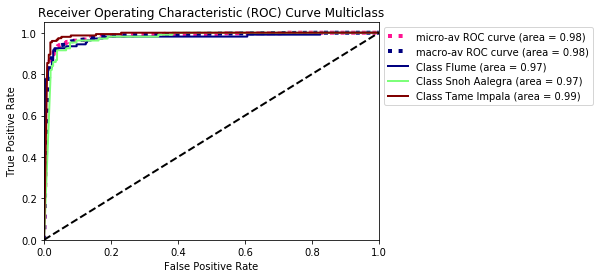

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


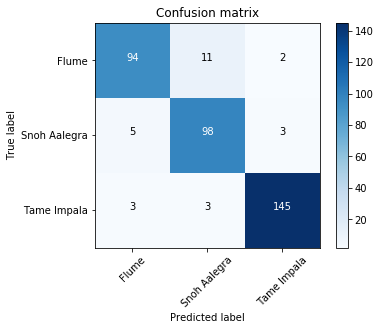

            Results
Accuracy   0.925824
Precision  0.926716
Recall     0.925824
F1         0.925916



Logistic regression classifier



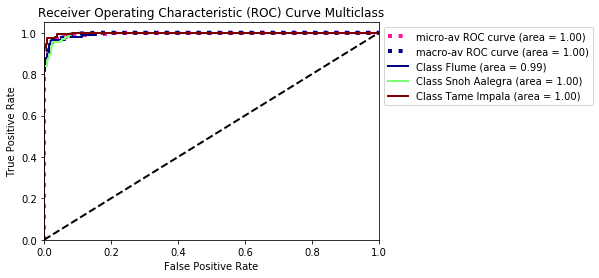

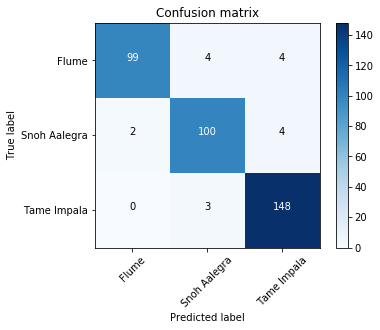

            Results
Accuracy   0.953297
Precision  0.953854
Recall     0.953297
F1         0.953230


K nearest neighbors classifier



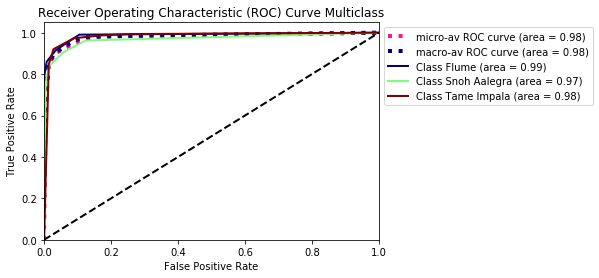

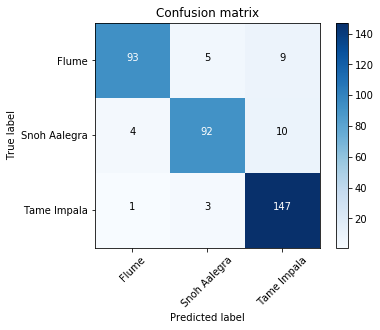

            Results
Accuracy   0.912088
Precision  0.914224
Recall     0.912088
F1         0.911557


In [98]:
%matplotlib inline
#Implement classification methods
rs = random.seed(15)#set random seed
classes, y = np.unique(new_labels, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(Sgt_spec, y, test_size=.33, random_state=rs)

""" CLASSIFICATION MODELS """
#Linear Discriminant Analysis (LDA)
clf = LinearDiscriminantAnalysis(tol=0.01)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_lda = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_lda)#print series of evaluation metrics

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################

# k Nearest Neighbors classifier
print ('\n\nK nearest neighbors classifier\n')
k = 5 # number of neighbors
distance_metric = 'euclidean'
#set up model
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, knn, classes)
knn.fit(X_train, y_train)#train the model
preds_knn = knn.predict(X_test)#test the model
aScore = accuracy_score(y_test, preds_knn)#accuracy score
CM = confusion_matrix(y_test, preds_knn)# Confusion Matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_knn, average='weighted')#precision score
R = recall_score(y_test, preds_knn, average='weighted')#recall score
F1 = f1_score(y_test, preds_knn, average='weighted')#F1 score
a = {'Results': [aScore, P, R, F1]}#series of evaluation results
aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_k)
###################

In [99]:
#read in wave files, get song names
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/Part2_songs/"
songs = []
sample_rates = []
names = []
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".wav"):
            song_path = os.path.join(parent_dir, file)
            sr, data = wavfile.read(song_path)
            if data.ndim == 2:
                song_ = data.T[0] / 32768 # grab one stereo channel, this is 16-bit track, now normalized on [-1,1) 
            else:
                song_ = data.T / 32768
            song = np.trim_zeros(song_)#trims trailing and leading zeros from start and end of song
            songs.append(song)
            sample_rates.append(sr)
            names.append(file)

#clean up file names to use as artist labels
labels = []#hold artist labels for songs
for name in names:
    artist = name.split(' - ')[0]
    labels.append(artist)

#split songs into 5 second chunks and create data matrix
sample_length = 5 #desired length of song samples in seconds
data_list = []
new_labels = []
for i in range(0, len(songs)):
    print("Progress {:2.1%}".format(i / len(songs)), end="\r")#print progress of paint can position acquisition
    num_entries = sample_rates[0]*sample_length#some songs have 44100 Hz sampling rates.. use 48000 Hz so array lengths are constant between songs
    sample = []
    song = songs[i]
    for j in range(0, len(song)):
        if (j % (num_entries) == 0) and (not(j == 0)):
            artist = labels[i]#get artist name
            new_labels.append(artist)#add artist name to label list for new data list of 5 second samples
            data_list.append(sample)#create data entry of 5 second sample
            sample = []
        sample.append(song[j])
        
data_jazz = np.vstack(data_list)#concatenate list of song sample arrays into one numpy array, each row is a sample

In [100]:
#compute frequency spectrum for each song sample
r, c = data_jazz.shape#get shape of data array
Sgt_spec = np.empty((r, c))#array for storing frequency spectrum data for song samples
for i in range(0, r):
    Sgt = np.fft.fft2(data_jazz[i,:].reshape((1, len(data_jazz[i,:])))) #calculate fourier transform of song sample
    Sgt_spec[i, :] = abs(np.fft.fftshift(Sgt)) #save shifted fourier transform for spectrogram plotting

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


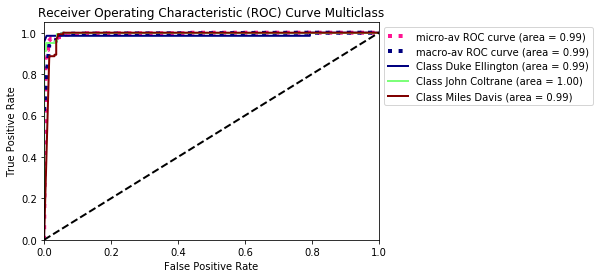

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


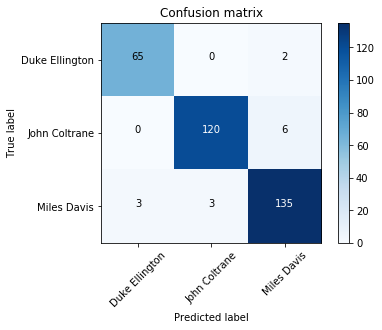

            Results
Accuracy   0.958084
Precision  0.958332
Recall     0.958084
F1         0.958125



Logistic regression classifier



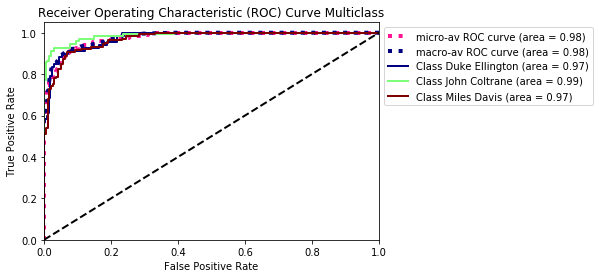

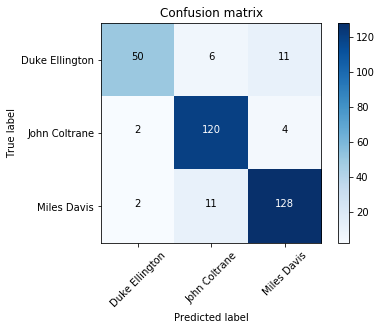

            Results
Accuracy   0.892216
Precision  0.894047
Recall     0.892216
F1         0.890573


K nearest neighbors classifier



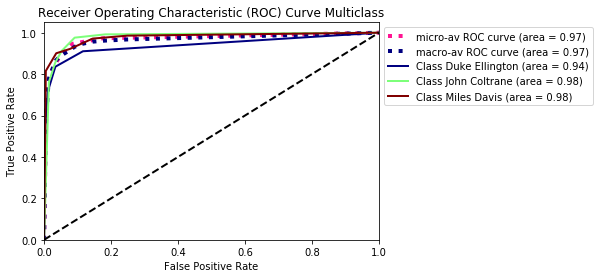

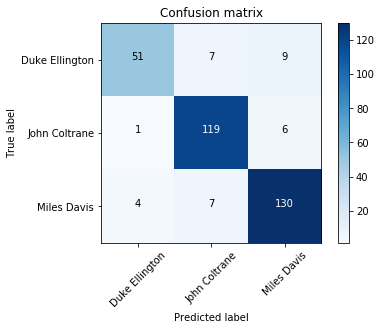

            Results
Accuracy   0.898204
Precision  0.898708
Recall     0.898204
F1         0.896786


In [101]:
%matplotlib inline
#Implement classification methods
rs = random.seed(15)#set random seed
classes, y = np.unique(new_labels, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(Sgt_spec, y, test_size=.33, random_state=rs)

""" CLASSIFICATION MODELS """
#Linear Discriminant Analysis (LDA)
clf = LinearDiscriminantAnalysis(tol=0.01)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_lda = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_lda)#print series of evaluation metrics

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################

# k Nearest Neighbors classifier
print ('\n\nK nearest neighbors classifier\n')
k = 5 # number of neighbors
distance_metric = 'euclidean'
#set up model
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, knn, classes)
knn.fit(X_train, y_train)#train the model
preds_knn = knn.predict(X_test)#test the model
aScore = accuracy_score(y_test, preds_knn)#accuracy score
CM = confusion_matrix(y_test, preds_knn)# Confusion Matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_knn, average='weighted')#precision score
R = recall_score(y_test, preds_knn, average='weighted')#recall score
F1 = f1_score(y_test, preds_knn, average='weighted')#F1 score
a = {'Results': [aScore, P, R, F1]}#series of evaluation results
aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_k)
###################

In [102]:
#read in wave files, get song names
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH582/HW4/Part3_songs/"
songs = []
sample_rates = []
names = []
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        if file.endswith(".wav"):
            song_path = os.path.join(parent_dir, file)
            sr, data = wavfile.read(song_path)
            if data.ndim == 2:
                song_ = data.T[0] / 32768 # grab one stereo channel, this is 16-bit track, now normalized on [-1,1) 
            else:
                song_ = data.T / 32768
            song = np.trim_zeros(song_)#trims trailing and leading zeros from start and end of song
            songs.append(song)
            sample_rates.append(sr)
            names.append(file)

#clean up file names to use as artist labels
labels = []#hold artist labels for songs
for name in names:
    artist = name.split(' - ')[0]
    labels.append(artist)

#split songs into 5 second chunks and create data matrix
sample_length = 5 #desired length of song samples in seconds
data_list = []
new_labels = []
for i in range(0, len(songs)):
    print("Progress {:2.1%}".format(i / len(songs)), end="\r")#print progress of paint can position acquisition
    num_entries = sample_rates[0]*sample_length#some songs have 44100 Hz sampling rates.. use 48000 Hz so array lengths are constant between songs
    sample = []
    song = songs[i]
    for j in range(0, len(song)):
        if (j % (num_entries) == 0) and (not(j == 0)):
            artist = labels[i]#get artist name
            new_labels.append(artist)#add artist name to label list for new data list of 5 second samples
            data_list.append(sample)#create data entry of 5 second sample
            sample = []
        sample.append(song[j])
        
data_genre = np.vstack(data_list)#concatenate list of song sample arrays into one numpy array, each row is a sample

In [103]:
#compute frequency spectrum for each song sample
r, c = data_genre.shape#get shape of data array
Sgt_spec = np.empty((r, c))#array for storing frequency spectrum data for song samples
for i in range(0, r):
    Sgt = np.fft.fft2(data_genre[i,:].reshape((1, len(data_genre[i,:])))) #calculate fourier transform of song sample
    Sgt_spec[i, :] = abs(np.fft.fftshift(Sgt)) #save shifted fourier transform for spectrogram plotting

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


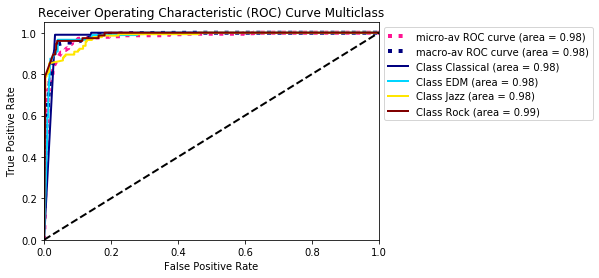

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


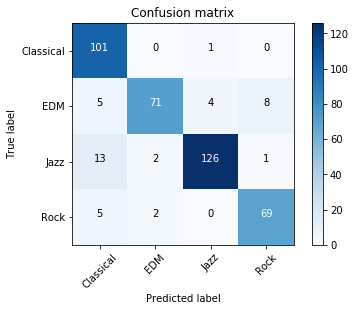

            Results
Accuracy   0.899510
Precision  0.907349
Recall     0.899510
F1         0.899538



Logistic regression classifier



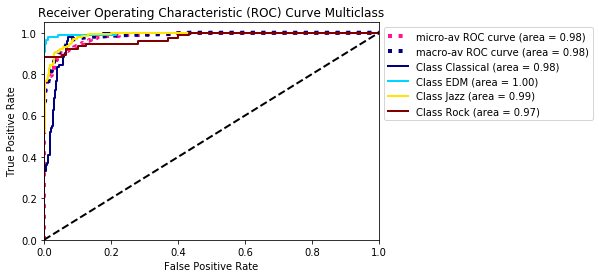

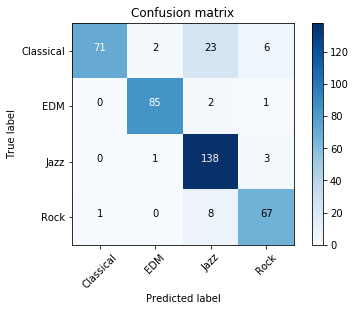

            Results
Accuracy   0.884804
Precision  0.897818
Recall     0.884804
F1         0.882396


K nearest neighbors classifier



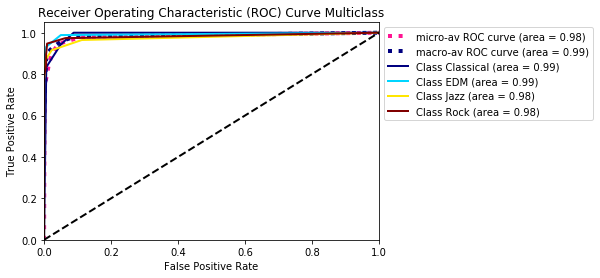

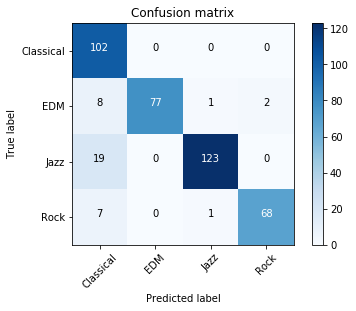

            Results
Accuracy   0.906863
Precision  0.926609
Recall     0.906863
F1         0.909774


In [104]:
%matplotlib inline
#Implement classification methods
rs = random.seed(15)#set random seed
classes, y = np.unique(new_labels, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(Sgt_spec, y, test_size=.33, random_state=rs)

""" CLASSIFICATION MODELS """
#Linear Discriminant Analysis (LDA)
clf = LinearDiscriminantAnalysis(tol=0.01)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_lda = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_lda)#print series of evaluation metrics

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################

# k Nearest Neighbors classifier
print ('\n\nK nearest neighbors classifier\n')
k = 5 # number of neighbors
distance_metric = 'euclidean'
#set up model
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, knn, classes)
knn.fit(X_train, y_train)#train the model
preds_knn = knn.predict(X_test)#test the model
aScore = accuracy_score(y_test, preds_knn)#accuracy score
CM = confusion_matrix(y_test, preds_knn)# Confusion Matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_knn, average='weighted')#precision score
R = recall_score(y_test, preds_knn, average='weighted')#recall score
F1 = f1_score(y_test, preds_knn, average='weighted')#F1 score
a = {'Results': [aScore, P, R, F1]}#series of evaluation results
aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_k)
###################